In [7]:
import numpy as np, cmath,scipy as sp
import scipy.io
from matplotlib import pyplot as plt

from numpy import pi, sin, cos, exp, sqrt, log,log10, random, convolve#import basic functions from numpy that we'll need
from numpy.fft import fft, ifft


%matplotlib inline

In [8]:
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

In [10]:
data = scipy.io.loadmat('sampleEEGdata')

In [11]:
#get all the data we need from the eeg file.

EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGepoch=data["EEG"][0,0]["epoch"][0]


which_channel_to_plot = 'FCz'; #specify label of channel to plot
EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]
channel_index = EEGchanlocslabels  == which_channel_to_plot #specify index (channel number) of label


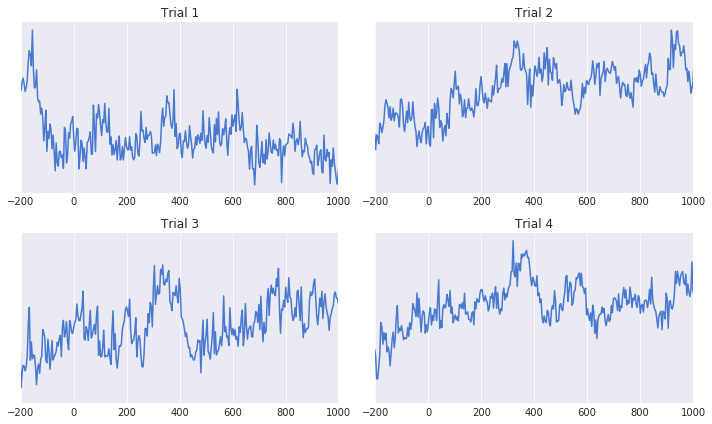

In [13]:
x_axis_limit = [-200,1000] #in milliseconds

num_trials2plot = 4

plt.figure(figsize=(10,6))
    
#pick a random trials using random.choice (from numpy.random)
random_trial_to_plot = [1,2,3,4]

for ii in range(num_trials2plot):
    
    #figure out how many subplots we need
    plt.subplot(np.ceil(num_trials2plot/np.ceil(sqrt(num_trials2plot))),np.ceil(sqrt(num_trials2plot)),ii+1)

    
    #plot trial and specify x-axis and title
    plt.plot(EEGtimes,np.squeeze(EEGdata[channel_index,:,random_trial_to_plot[ii] - 1]))
    plt.title("Trial " + str(random_trial_to_plot[ii]))
    plt.yticks([])
    plt.xlim(x_axis_limit)
_=plt.tight_layout()    
    

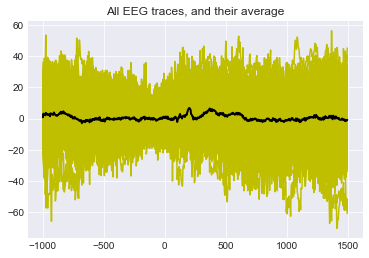

In [7]:
#plot all trials
plt.plot(EEGtimes,np.squeeze(EEGdata[channel_index,:,:]),'y')

#plot the event-related potential (ERP), i.e. the average time-domain signal
plt.plot(EEGtimes,np.squeeze(np.mean(EEGdata[channel_index,:,:],axis=2)),'k',linewidth=2)
_=plt.title("All EEG traces, and their average")

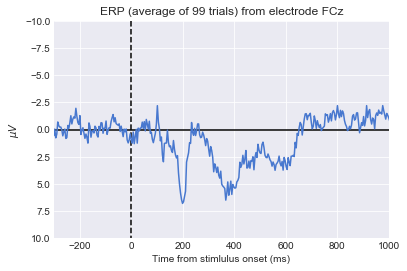

In [8]:
#now plot only the ERP
plt.plot(EEGtimes,np.squeeze(np.mean(EEGdata[channel_index,:,:],axis=2))) #axis=2 specifies which axis to compute the mean along
plt.vlines(0,-10,10,linestyles='dashed')
plt.hlines(0,-1000,1500)

plt.axis([-300,1000,-10,10])
plt.xlabel("Time from stimlulus onset (ms)")
plt.ylabel(r'$ \mu V $') #latex interpreter looks for dollar signs
plt.title("ERP (average of " + str(EEGtrials) + " trials) from electrode " + EEGchanlocslabels[channel_index][0][0])
plt.gca().invert_yaxis() #EEG convention to flip y axis

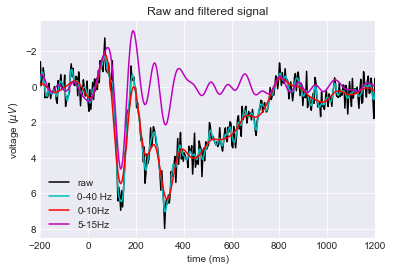

In [9]:
import scipy.signal as sig

chan2plot = "P7"

channel_index = EEGchanlocslabels  == chan2plot #specify index (channel number) of label

erp = np.squeeze(np.mean(EEGdata[channel_index,:,:],axis=2))

nyquist = EEGsrate/2.
transition_width = 0.15

#low-pass filter data

#filter form 0-40
filter_high = 40 #Hz; high cut off
b, a = sig.butter(5, np.array([filter_high*(1+transition_width)])/nyquist,btype="lowpass")
erp_0to40 = sig.filtfilt(b, a, erp, padlen=150) #use filfilt (filters forwards and backwards to eliminate phase shift)

#next, filter from 0-10
filter_high = 10 #Hz
b, a = sig.butter(5, np.array([filter_high*(1+transition_width)])/nyquist,btype="lowpass")
erp_0to10 = sig.filtfilt(b, a, erp, padlen=150)

#next, filter from 5-15
filter_low = 5 #Hz

filter_high = 15 #Hz
b, a = sig.butter(5, np.array([filter_low*(1-transition_width), filter_high*(1+transition_width)])/nyquist,btype="bandpass")
erp_5to15 = sig.filtfilt(b, a, erp, padlen=150)

plt.figure()
plt.plot(EEGtimes,erp,'k')
plt.plot(EEGtimes,erp_0to40,'c')
plt.plot(EEGtimes,erp_0to10,'r')
plt.plot(EEGtimes,erp_5to15,'m')

plt.xlim([-200,1200])
plt.gca().invert_yaxis()
plt.xlabel("time (ms)")
plt.ylabel("voltage " + r"$(\mu V)$")
plt.title("Raw and filtered signal")
_=plt.legend(['raw','0-40 Hz','0-10Hz','5-15Hz']) 


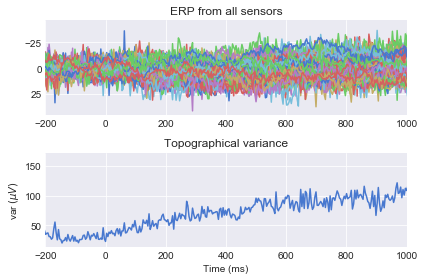

In [10]:
fig=plt.figure()

plt.subplot(211)
plt.plot(EEGtimes,np.squeeze(EEGdata.mean(axis=0)))
plt.xlim([-200, 1000])
plt.gca().invert_yaxis() #flip for EEG conventions
plt.title("ERP from all sensors")


#topographical variance plot

plt.subplot(212)
plt.plot(EEGtimes,np.squeeze(EEGdata.mean(axis=0).var(axis=1)))
plt.xlim([-200,1000])
plt.xlabel("Time (ms)")
plt.ylabel("var "+r'$ (\mu V) $')
plt.title("Topographical variance")


plt.tight_layout()

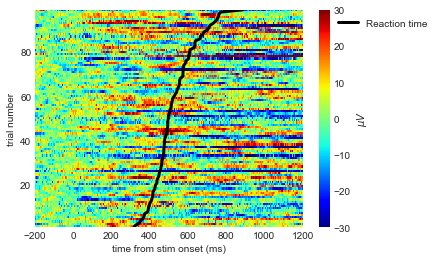

In [12]:
useRTs = True #or false

#get RTs from each trial to use for sorting trials.

rts = np.zeros(len(EEGepoch))

for ei in range(len(EEGepoch)):
    
    #first, find the index at which time = 0 event occurs
    time0event =  EEGepoch[ei]["eventlatency"][0]  == 0 #bool array of where time=0 occurs
    time0event = np.where(time0event == time0event.max())[0][0] # find the index of the True value in this array
    
    rts[ei] = EEGepoch[ei]["eventlatency"][0][time0event+1]
    

if useRTs:
    rts_idx=np.argsort(rts)
else:
    rts_idx = np.argsort(np.squeeze(EEGdata[46,333,:]))
    

#plot the trials for one channel, in (un)sorted order
plt.imshow(np.squeeze(EEGdata[46,:,rts_idx]), 
           extent=[EEGtimes[0], EEGtimes[-1], 1, EEGtrials],
           aspect="auto",
           cmap=plt.get_cmap("jet"),
           origin="lower",
           interpolation="none")


plt.xlabel("time from stim onset (ms)")
plt.ylabel("trial number")
plt.clim([-30,30])
plt.colorbar(label=r"$\mu V$")
plt.axis([-200,1200,1,99])
plt.grid(False)

if useRTs:
    rtplot=plt.plot(rts[rts_idx],np.arange(1,EEGtrials+1),'k',linewidth=3, label= "Reaction time")
    plt.legend(bbox_to_anchor=[1.5,1]) #put the legend outside of the image